## 환경설정

### 로깅 / 환경변수

In [1]:
from dotenv import load_dotenv
from modules import logging

In [2]:
# LangSmith Logging
logging.langsmith("Model_RAG")
# API 키 정보 로드
load_dotenv()

LangSmith 추적을 시작합니다.
[프로젝트명]
Model_RAG


True

### 파일 로드

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings

In [4]:
ollama_embeddings = OllamaEmbeddings(
    model="nomic-embed-text"
)

loaded_db = FAISS.load_local(
    folder_path="faiss_db",
    index_name="meritz_index",
    embeddings=ollama_embeddings,
    allow_dangerous_deserialization=True,
)

C:\Users\vkxql\AppData\Local\Temp\ipykernel_6300\4185708034.py:1: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  ollama_embeddings = OllamaEmbeddings(


### LLM

In [5]:
from langchain_openai import ChatOpenAI

In [6]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Retriever

In [7]:
from langchain.retrievers.multi_query import MultiQueryRetriever

In [8]:
# MultiQueryRetriever 설정
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=loaded_db.as_retriever(),
    llm=llm
)

## 상태 정의

In [9]:
from langchain.schema import BaseMessage
from typing_extensions import Annotated, Literal, Sequence, TypedDict

class state(TypedDict):
    # 메시지 관리 (사용자와 시스템의 대화 기록)
    messages: Annotated[Sequence[BaseMessage], "add_messages"]
    # 세션 ID (각 워크플로우 인스턴스에 고유한 ID)
    session_id: str
    # 기타 메타데이터 (사용자 정보, 소스 등)
    metadata: dict
    # 검색된 문서 리스트
    retrieved_docs: list  # 검색 결과 (MultiQueryRetriever의 반환 값)
    # 생성된 최종 답변
    generated_response: str  # 시스템의 최종 답변


In [10]:
from langgraph.checkpoint.memory import MemorySaver

In [11]:
import uuid

In [12]:
session_id = str(uuid.uuid4())

In [13]:
memory = MemorySaver()

## 노드

### Agent

In [14]:
def agent(state: state) -> state:
    """
    Initial agent node to process the user's question and pass it to the MultiQueryRetriever.
    """
    print("---AGENT NODE ACTIVATED---")
    user_question = state["messages"][-1]["content"]
    print(f"User Question: {user_question}")
    
    # 사용자 질문을 다음 노드로 전달
    state["current_question"] = user_question
    return state

### Retriever

In [15]:
def retriever_tool(state:state) -> state:
    """
    Retrieves documents using MultiQueryRetriever based on the current question.
    """
    print("---CALL RETRIEVE TOOL---")
    
    # 사용자의 마지막 질문
    user_question = state["messages"][-1]["content"]
    
    # MultiQueryRetriever에 사용할 프롬프트
    multi_query_prompt = f"""
    You are an expert assistant trained to optimize search queries for retrieving the most relevant documents.
    Given a user question, your task is to generate multiple rephrased versions of the same question. These
    rephrased questions should:
    
    1. Cover different ways a user might phrase the same question.
    2. Maintain the original intent and meaning of the question.
    3. Use synonyms, structural variations, and alternative expressions where applicable.

    For the following user question, generate at least **5 rephrased versions**:
    
    Original Question:
    "{user_question}"
    
    Ensure your rephrased versions are concise, clear, and ready to be used in a search query. Output the rephrased questions as a list.
    """
    
    # MultiQueryRetriever로 문서 검색
    retrieved_docs = multi_query_retriever.get_relevant_documents(multi_query_prompt)
    
    # 검색된 문서를 상태에 저장
    state["retrieved_docs"] = retrieved_docs
    return state


### Grade

In [16]:
def grade_documents(state: state) -> state:
    """
    Grades the retrieved documents to determine relevance to the user's question.
    """
    print("---GRADE DOCUMENTS NODE ACTIVATED---")
    
    retrieved_docs = state.get("retrieved_docs", [])
    current_question = state["current_question"]
    
    grading_prompt = f"""
    You are an expert in evaluating document relevance. Given the user's question and the retrieved documents,
    evaluate whether the documents are relevant or not.

    User Question:
    "{current_question}"

    Retrieved Documents (Summarized):
    {retrieved_docs}

    Respond with:
    - "Relevant" if the documents are relevant to the question.
    - "Not Relevant" if the documents are not relevant.
    """
    
    # LLM 평가
    relevance_result = llm(grading_prompt)
    state["document_grading"] = relevance_result.strip().lower()
    print(f"Document Grading: {state['document_grading']}")
    return state


### Rewrite

In [17]:
def rewrite(state: state) -> state:
    """
    Generates a new question if the retrieved documents are not relevant.
    """
    print("---REWRITE NODE ACTIVATED---")
    
    current_question = state["current_question"]
    rewrite_prompt = f"""
    The retrieved documents were not relevant to the following user question:
    "{current_question}"
    
    Please analyze the user's intent and generate a new question that better represents the user's intent
    to find relevant documents. Ensure the new question is concise and clear.
    """
    
    # LLM을 사용하여 질문 재작성
    rewritten_question = llm(rewrite_prompt)
    state["rewritten_question"] = rewritten_question.strip()
    print(f"Rewritten Question: {state['rewritten_question']}")
    return state


In [18]:
def generate(state: state) -> state:
    """
    Generates the final response based on the user's question and relevant documents.
    """
    print("---GENERATE RESPONSE NODE ACTIVATED---")
    
    current_question = state["current_question"]
    retrieved_docs = state["retrieved_docs"]
    
    response_prompt = f"""
    User Question:
    "{current_question}"
    
    Relevant Documents:
    {retrieved_docs}
    
    Generate a concise and accurate response to the user's question based on the provided information.
    """
    
    # LLM을 사용하여 최종 답변 생성
    generated_response = llm(response_prompt)
    state["generated_response"] = generated_response.strip()
    print(f"Generated Response: {state['generated_response']}")
    return state


## Workflow

In [19]:
from langgraph.graph import StateGraph, START, END

In [20]:
workflow = StateGraph(state)

### add node

In [21]:
dddd

NameError: name 'dddd' is not defined

In [22]:
workflow.add_node("agent", agent)
workflow.add_node("retriever_tool", retriever_tool)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

In [ ]:
# 노드 간 기본 연결
workflow.add_edge(START, "agent")
workflow.add_edge("agent", "retriever_tool")
workflow.add_edge("retriever_tool", "grade_documents")

# 조건부 연결 추가
def conditional_decision(state):
    """
    조건부 경로를 결정하는 함수.
    'grade_documents' 결과에 따라 경로가 나뉨.
    """
    if state.get("document_grading") == "relevant":
        return "generate"
    else:
        return "rewrite"

workflow.add_conditional_edges(
    "grade_documents",
    
    conditional_decision,  # 조건 함수
     path_map={
        "generate": "generate",     # Generate로 이어지는 경우 END로 연결
        "rewrite": "rewrite"   # Rewrite로 이어지는 경우 Agent로 루프
    }
)
# 다른 연결 추가
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

In [25]:
graph = workflow.compile(checkpointer=memory)

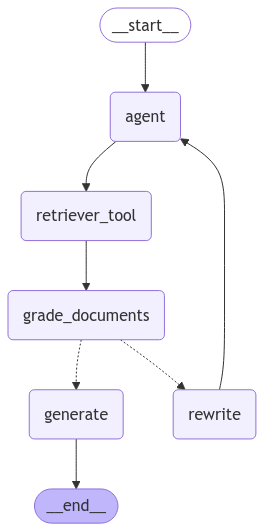

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
import pprint

# 입력 데이터 정의
inputs = {
    "messages": [
        ("user", "대인 부분 약관과 보장 범위에 대해 알려줘."),
    ]
}

# Configurable 설정 (필요한 경우)
config = {"configurable": {"thread_id": "user_123"}}

# 그래프 스트림 실행
for output in graph.stream(inputs, config=config):
    # 각 노드의 출력 처리
    for key, value in output.items():
        print(f"\n{'-'*10} Output from node '{key}' {'-'*10}\n")
        
        # 메시지가 포함된 경우만 출력
        if "messages" in value:
            for message in value["messages"]:
                if hasattr(message, "content") and message.content:
                    print(f"**Message Content**:\n{message.content}\n")
        else:
            pprint.pprint(value, indent=2, width=80, depth=None)
        
        print("\n" + "-"*30 + "\n")


---AGENT NODE ACTIVATED---


TypeError: tuple indices must be integers or slices, not str